In [1]:
import os
dataset_dir = "Flickr8k_Dataset"
os.makedirs(dataset_dir, exist_ok=True)
print("Downloading Flickr8k dataset...")

In [2]:
!wget https://github.com/awsaf49/flickr-dataset/releases/download/v1.0/flickr8k.zip

--2025-09-11 17:24:38--  https://github.com/awsaf49/flickr-dataset/releases/download/v1.0/flickr8k.zip
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/753516996/d7c62b13-1e50-40ea-8fae-f34a44b1695f?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-09-11T18%3A15%3A26Z&rscd=attachment%3B+filename%3Dflickr8k.zip&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-09-11T17%3A14%3A33Z&ske=2025-09-11T18%3A15%3A26Z&sks=b&skv=2018-11-09&sig=qeK8j2c2BEYIMACfXzM0vhl%2BdxJnXgsNd%2FGblKsCXbQ%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc1NzYxMTc3OCwibmJmIjoxNzU3NjExNDc4LCJwYXRoIjoicmVsZWFzZWFzc2V0cHJvZHVjdGlvbi5ibG9

In [3]:
import zipfile
with zipfile.ZipFile("flickr8k.zip", 'r') as zip_ref:
    zip_ref.extractall(dataset_dir)
os.remove("flickr8k.zip")

In [ ]:
!pip install tqdm

# Tutorial: Image Captioning using CNN and RNN

Image Captioning takes both Image and text as input.

To extract the features from Images, CNN is used; whereas for text processing, RNN is used.

# Dataset

We are using Flicker8k dataset. It has:

a. 8,000 images covering a wide range of everyday scenes.

b. 5 captions per image, providing rich textual descriptions.

# File strcture

The top folder contains "Images" folder containing images, and "captions.txt" file, which maps the images and the text data.

# Importing Libraries

In [4]:
import os
import re
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from collections import Counter
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


# Defining Hyperparameters

In [ ]:
train_ratio = 0.7
val_ratio = 0.1
test_ratio = 0.2
batch_size = 64
embed_size = 256
hidden_size = 512
num_epochs = 10
lr = 0.00001

# Loading Dataset, Preprocessing

# Preprocessing


1. **Text Pre-processing**

a. **Vocabulary Building**

Vocabulary is built from all captions in the dataset, assigning a unique index to each word. A Vocabulary class is created to map words to indices (stoi) and indices to words (itos).

Special tokens are added:

**start of caption, end of caption** -> These are used to indicate the starting and ending of the sentence

**unknown words** -> We build vocabulary generally from a large dataset or training set. There might be instances where some texts are not in the vocabulary, for e.g., the vocabulary is British English, but our dataset is American English or we encounter some new names, so some data can't be mapped to the vocabulary.

**padding** -> In general, we fix the length of the input captions. But captions might have different lengths. So, we fix the maximum length and fill the captions with zeros.


b. **Tokenization**

The sentences are built using words. We extract the words from sentences and map each words to some numbers using Vocabulary.

Captions are tokenized using a simple regex (\w+|\\.), splitting words and keeping punctuation, convert the Captial letters to small letters.

Example:

Maximum sequence length: 10

Input: We study in IIT Bombay.

After Tokenization: "\<SOS\>", "we", "study", "in", "\<UNK\>", "bombay", ".",  "\<EOS\>", "\<PAD\>", "\<PAD\>"

We feed this in numbers.



2. **Image Pre-processing**

Images are:

a. Resized to (224, 224)

b. Converted to tensors

c. Normalized using ImageNet mean and standard deviation:

Mean: [0.485, 0.456, 0.406]

Std: [0.229, 0.224, 0.225]

3. **Dataset Splitting and Loading**

(Image, Caption) pairs are split into train, validation, and test sets.

Create dataloader with Custom collate_fn to handle variable-length captions and indicate the start, end of sentence, padding for the captions.

Stacks image tensors to form a batch of shape [batch_size, channels, height, width].
Stacks caption tensors to form a batch of shape [batch_size, tokenized_text].

In [ ]:
# ------------------ Vocabulary Class ------------------
class Vocabulary:
    def __init__(self):
        # Initialize with special tokens
        self.itos = {0: "<pad>", 1: "<start>", 2: "<end>", 3: "<unk>"}  # index-to-string
        self.stoi = {v: k for k, v in self.itos.items()}  # string-to-index

    def tokenizer(self, text):
        # Simple tokenizer: split text into words and keep periods as separate tokens
        return re.findall(r'\w+|\.', text.lower())

    def build_vocabulary(self, sentence_list):
        # Build vocab from list of sentences
        frequencies = Counter()
        for sentence in sentence_list:
            tokens = self.tokenizer(sentence)
            frequencies.update(tokens)

        # Continue indexing new words after special tokens
        idx = max(self.stoi.values()) + 1
        for word, freq in frequencies.items():
            if word not in self.stoi:  # only add unseen words
                self.stoi[word] = idx
                self.itos[idx] = word
                idx += 1

    def numericalize(self, text):
        # Convert tokens in a sentence into indices
        # Unseen words become <unk>
        return [int(self.stoi.get(token, self.stoi["<unk>"]))
                for token in self.tokenizer(text)]

    def __len__(self):
        # Size of vocabulary
        return len(self.stoi)


# ------------------ Collate Function ------------------
def collate_fn(batch, vocab):
    # batch is a list of (image, caption) pairs
    images, captions_list = zip(*batch)

    # Stack images into a single tensor
    images = torch.stack(images, 0)

    captions = []
    for cap in captions_list:
        # Convert caption to token indices with <start> and <end> markers
        tokens = [vocab.stoi["<start>"]] + vocab.numericalize(cap) + [vocab.stoi["<end>"]]
        captions.append(torch.tensor(tokens, dtype=torch.long))

    # Find longest caption in batch to pad others
    max_len = max(len(cap) for cap in captions)
    targets = torch.zeros(len(captions), max_len).long()  # batch_size x max_len

    for i, cap in enumerate(captions):
        targets[i, :len(cap)] = cap  # pad with zeros (<pad> token)

    return images, targets


# ------------------ Dataset ------------------
class CaptionDatasetCSV(Dataset):
    def __init__(self, img_dir, captions_file, vocab, transform=None):
        self.img_dir = img_dir
        self.df = pd.read_csv(captions_file)  # load full captions dataframe
        self.vocab = vocab
        self.transform = transform

    def __len__(self):
        return len(self.df)  # number of (image, caption) pairs

    def __getitem__(self, idx):
        # Retrieve image ID and caption from dataframe
        img_id = self.df.iloc[idx, 0]
        caption = self.df.iloc[idx, 1]

        # Load image from disk and convert to RGB
        image = Image.open(os.path.join(self.img_dir, img_id)).convert("RGB")

        # Apply transforms if provided (resize, normalize, etc.)
        if self.transform:
            image = self.transform(image)

        return image, caption


# ------------------ Dataset Preparation ------------------
dataset_dir = "/content/Flickr8k_Dataset"
img_dir = os.path.join(dataset_dir, "Images")
captions_file = os.path.join(dataset_dir, "captions.txt")

# Load captions file
df = pd.read_csv(captions_file)

# Get unique image IDs (since each image has multiple captions)
img_ids = df['image'].unique()

# Split into train/val/test sets based on image IDs
train_val_ids, test_ids = train_test_split(img_ids,test_size=test_ratio,random_state=42)
train_ids, val_ids = train_test_split(train_val_ids,test_size=val_ratio / (train_ratio + val_ratio),random_state=42)


# Build vocabulary from all captions
vocab = Vocabulary()
vocab.build_vocabulary(df['caption'].tolist())

# Image transformations (resize, convert to tensor, normalize)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Create dataset objects (initially load full df)
train_dataset = CaptionDatasetCSV(img_dir, captions_file, vocab, transform)
val_dataset = CaptionDatasetCSV(img_dir, captions_file, vocab, transform)
test_dataset = CaptionDatasetCSV(img_dir, captions_file, vocab, transform)

# Overwrite the df in each dataset with only the rows for that split
train_dataset.df = df[df['image'].isin(train_ids)]
val_dataset.df = df[df['image'].isin(val_ids)]
test_dataset.df = df[df['image'].isin(test_ids)]

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          collate_fn=lambda x: collate_fn(x, vocab))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                        collate_fn=lambda x: collate_fn(x, vocab))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                          collate_fn=lambda x: collate_fn(x, vocab))


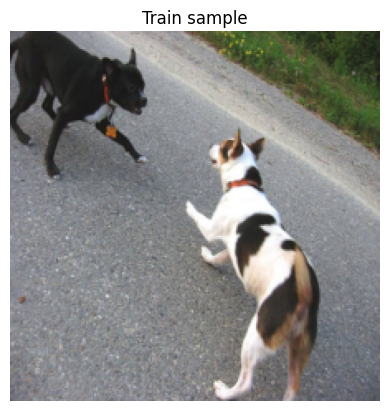

Captions (5):
  1. A black dog and a spotted dog are fighting
  2. A black dog and a tri-colored dog playing with each other on the road .
  3. A black dog and a white dog with brown spots are staring at each other in the street .
  4. Two dogs of different breeds looking at each other on the road .
  5. Two dogs on pavement moving toward each other .


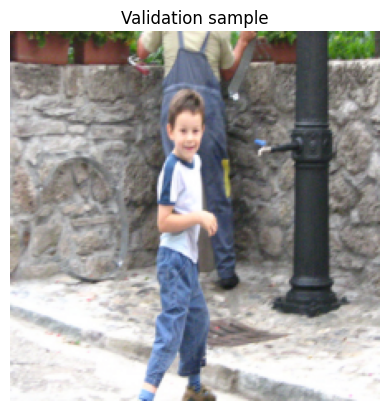

Captions (5):
  1. A boy smiles in front of a stony wall in a city .
  2. A little boy is standing on the street while a man in overalls is working on a stone wall .
  3. A young boy runs aross the street .
  4. A young child is walking on a stone paved street with a metal pole and a man behind him .
  5. Smiling boy in white shirt and blue jeans in front of rock wall with man in overalls behind him .


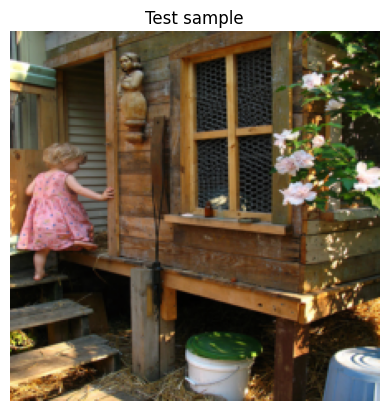

Captions (5):
  1. A child in a pink dress is climbing up a set of stairs in an entry way .
  2. A girl going into a wooden building .
  3. A little girl climbing into a wooden playhouse .
  4. A little girl climbing the stairs to her playhouse .
  5. A little girl in a pink dress going into a wooden cabin .


In [ ]:
# ------------------ Denormalize ------------------
def denormalize(img_tensor):
    """
    Undo ImageNet normalization for visualization.
    """
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = img_tensor.cpu() * std + mean  # unnormalize
    img = torch.clamp(img, 0, 1)         # clip values to [0,1]
    return transforms.ToPILImage()(img)


# ------------------ Show Sample Function ------------------
def show_sample(dataset, split_name="train", idx=0):
    """
    Show an image and all its captions from a dataset split.
    """
    # Get one (image, caption) pair
    img, _ = dataset[idx]

    # Retrieve image filename
    img_id = dataset.df.iloc[idx]["image"]

    # Collect all captions for this image
    all_captions = dataset.df[dataset.df["image"] == img_id]["caption"].tolist()

    # Display image (denormalized)
    plt.imshow(denormalize(img))
    plt.axis("off")
    plt.title(f"{split_name} sample")
    plt.show()

    # Print captions
    print(f"Captions ({len(all_captions)}):")
    for i, cap in enumerate(all_captions, 1):
        print(f"  {i}. {cap}")


# ------------------ Show Train / Val / Test Samples ------------------
show_sample(train_dataset, "Train", idx=0)
show_sample(val_dataset, "Validation", idx=0)
show_sample(test_dataset, "Test", idx=0)


# Model

1. **Encoder (CNN)**

The encoder is based on a pretrained ResNet-50 model (trained on ImageNet).

We remove the final classification layer and use the convolutional backbone to extract high-level visual features from the image.

These features are then projected into a lower-dimensional embedding space using a fully connected layer, followed by BatchNorm for stability.

Output is a feature vector that represents the entire image.

2. **Decoder (RNN)**

The decoder is a Recurrent Neural Network (RNN) that generates the caption one word at a time.

It consists of:

Word Embedding layer: converts each token in the caption into a dense vector of size embed_size. The goal of embedding layer is to make similar words have similar features, e.g., "dog" and "puppy".

RNN layer: processes the sequence of embeddings (starting with the image feature vector) and maintains a hidden state that captures context.

Fully connected output layer: maps hidden states to a probability distribution over the vocabulary.

The decoder is initialized with the image features, so the generated sequence is conditioned on the input image.

3. **Training Strategy**

During training, we use teacher forcing: the decoder sees the ground-truth caption tokens (shifted by one step) as inputs.

The loss is computed over the predicted sequence vs. the actual target caption.

4. **Inference (Caption Generation)**

At test time, the model generates captions using a greedy decoding strategy:

Start with the image features as input.

Predict the next word, append it to the sequence.

Feed the predicted word back into the RNN.

Stop when the \<eos\> token is predicted or when the maximum length is reached.

# Image Captioning Architecture

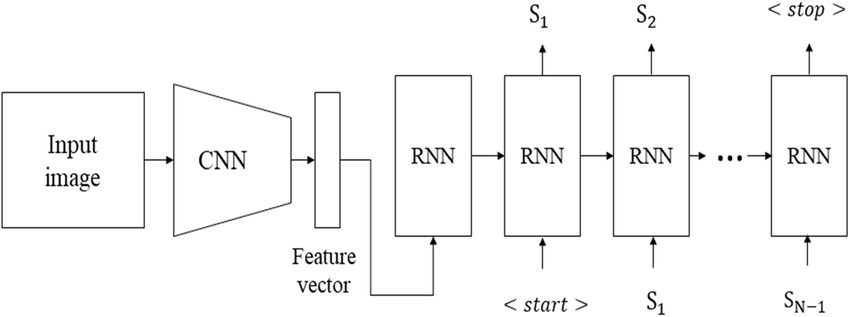

# Teacher Forcing

Ground truth: Two people running ...

If the first two words of the generated caption are "Two birds", then the next probable word is "flying" rather than "running". Thus, incorrect generation on one position will affect the subsequent words.

Solution: Use the ground truths directly rather than the previous timestep outputs.


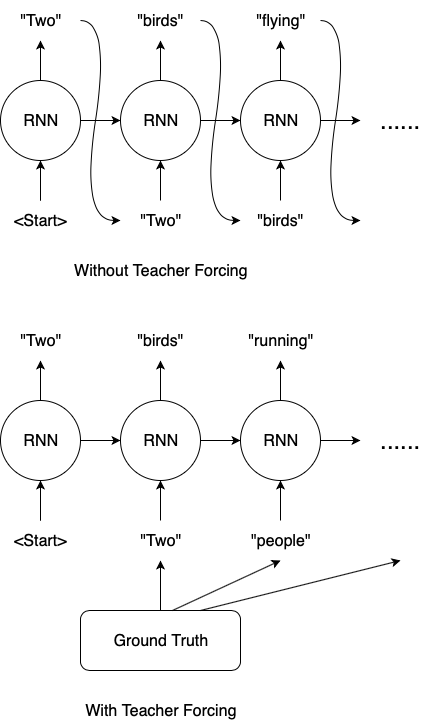

In [28]:
# ------------------ Encoder ------------------
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super().__init__()
        # Load pretrained ResNet-50 (with weights from ImageNet)
        resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

        # Freeze all ResNet parameters so they are not trained
        for param in resnet.parameters():
            param.requires_grad = False

        # Remove the last fully-connected classification layer
        modules = list(resnet.children())[:-1]  # keep everything except fc
        self.resnet = nn.Sequential(*modules)

        # Add a fully connected layer to project ResNet output -> embedding size
        self.fc = nn.Linear(resnet.fc.in_features, embed_size)

        # Normalize features for stable training
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)

    def forward(self, images):
        # Extract CNN features
        features = self.resnet(images)   # shape: (batch, 2048, 1, 1)
        features = features.view(features.size(0), -1)  # flatten -> (batch, 2048)
        features = self.bn(self.fc(features))           # project -> (batch, embed_size)
        return features


# ------------------ Decoder ------------------
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super().__init__()
        # Embedding layer for words (vocab_size → embed_size)
        self.embed = nn.Embedding(vocab_size, embed_size)

        # RNN layer (simple RNN, could also be LSTM/GRU)
        self.rnn = nn.RNN(embed_size, hidden_size, num_layers, batch_first=True)

        # Fully connected output layer (hidden_size → vocab_size)
        self.linear = nn.Linear(hidden_size, vocab_size)

        # Store RNN parameters
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Initialize hidden state from image features
        self.init_h = nn.Linear(embed_size, hidden_size)

    def forward(self, features, captions):
        # captions: (batch, seq_len), where first token is <start>
        embeddings = self.embed(captions[:, :-1])  # shift right (teacher forcing)

        # Prepend image features as the first timestep
        features = features.unsqueeze(1)  # (batch, 1, embed_size)
        embeddings = torch.cat((features, embeddings), dim=1)  # (batch, seq_len+1, embed_size)

        # Initialize hidden state from image features
        h0 = self.init_h(features.squeeze(1))  # (batch, hidden_size)
        h0 = h0.unsqueeze(0).repeat(self.num_layers, 1, 1)  # (num_layers, batch, hidden_size)

        # Pass through RNN
        outputs, _ = self.rnn(embeddings, h0)

        # Map RNN outputs to vocab scores
        outputs = self.linear(outputs)  # (batch, seq_len+1, vocab_size)
        return outputs

    def sample(self, features, max_len=20):
        """
        Generate caption for given image features (greedy decoding).
        """
        sampled_ids = []

        # First input is the image features
        inputs = features.unsqueeze(1)  # (batch=1, 1, embed_size)
        h = self.init_h(features).unsqueeze(0).repeat(self.num_layers, 1, 1)

        for _ in range(max_len):
            # Run RNN one step
            outputs, h = self.rnn(inputs, h)

            # Project to vocab and pick highest probability word
            outputs = self.linear(outputs.squeeze(1))  # (batch=1, vocab_size)
            _, predicted = outputs.max(1)              # predicted word index
            sampled_ids.append(predicted.item())

            # Stop if <end> token is predicted (id=2)
            if predicted.item() == 2:
                break

            # Next input is embedding of predicted word
            inputs = self.embed(predicted).unsqueeze(1)

        return sampled_ids


# ------------------ Combined Model ------------------
class ImageCaptioningModel(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super().__init__()
        # Encoder (CNN extracts image features)
        self.encoder = EncoderCNN(embed_size)

        # Decoder (RNN generates caption from features)
        self.decoder = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers)

    def forward(self, images, captions):
        # Encode images
        features = self.encoder(images)

        # Decode captions
        outputs = self.decoder(features, captions)
        return outputs

    def sample(self, images, max_len=20):
        # Generate caption for an image (used at inference time)
        features = self.encoder(images)
        sampled_ids = self.decoder.sample(features, max_len)
        return sampled_ids

In [29]:
vocab_size = len(vocab)
model = ImageCaptioningModel(embed_size, hidden_size, vocab_size).to(device)

In [34]:
dummy_images = torch.randn(1, 3, 224, 224).to(device)
dummy_captions = torch.randint(0, len(vocab), (1, 20), dtype=torch.long).to(device)

output = model(dummy_images, dummy_captions)
print(model)


ImageCaptioningModel(
  (encoder): EncoderCNN(
    (resnet): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=T

# Training Loop

In [ ]:
def train_model(model, train_loader, val_loader, vocab, num_epochs=5, lr=0.001):
    # Vocabulary size (number of output classes)
    vocab_size = len(vocab)

    # CrossEntropyLoss ignores <pad> tokens so they don’t affect training
    criterion = nn.CrossEntropyLoss(ignore_index=vocab.stoi["<pad>"])

    # Trainable parameters:
    # - Decoder (always trained)
    # - Encoder’s final FC + BatchNorm layers (rest of ResNet is frozen)
    params = (
        list(model.decoder.parameters()) +
        list(model.encoder.fc.parameters()) +
        list(model.encoder.bn.parameters())
    )

    # Adam optimizer for training
    optimizer = torch.optim.Adam(params, lr=lr)

    # ------------------ Training Loop ------------------
    for epoch in range(num_epochs):
        model.train()  # set model to training mode

        # Iterate over training batches
        for i, (images, captions) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}")):
            images, captions = images.to(device), captions.to(device)

            optimizer.zero_grad()  # reset gradients

            # Forward pass (encoder + decoder)
            outputs = model(images, captions)  # shape: (batch, seq_len, vocab_size)

            # Targets are the captions
            targets = captions[:, :outputs.size(1)].reshape(-1)  # flatten to 1D

            # Compute cross-entropy loss
            loss = criterion(outputs.reshape(-1, vocab_size), targets)

            # Backpropagation
            loss.backward()
            optimizer.step()

        # Print last batch loss for this epoch
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

        # ------------------ Validation ------------------
        model.eval()  # set model to evaluation mode
        total_loss = 0

        with torch.no_grad():  # no gradient calculation
            for images, captions in tqdm(val_loader, desc="Validation"):
                images, captions = images.to(device), captions.to(device)
                outputs = model(images, captions)

                targets = captions[:, :outputs.size(1)].reshape(-1)
                loss = criterion(outputs.reshape(-1, vocab_size), targets)

                total_loss += loss.item()

        # Average validation loss
        print(f"Validation Loss after Epoch {epoch+1}: {total_loss / len(val_loader):.4f}")

        # Save checkpoint for this epoch
        torch.save(model.state_dict(),f"model_epoch_{epoch+1}.pth")


# Run training for 10 epochs
train_model(model, train_loader, val_loader, vocab, num_epochs, lr)


# Sample image captioning

Generated Caption: a brown dog is running through a grassy field .

Ground Truth Captions:
1. A brown dog chases the water from a sprinkler on a lawn .
2. a brown dog plays with the hose .
3. A brown dog running on a lawn near a garden hose
4. A dog is playing with a hose .
5. Large brown dog running away from the sprinkler in the grass .


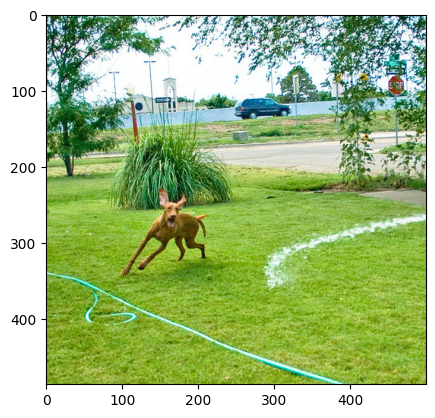

In [9]:
# Load model weights from saved checkpoint
model.load_state_dict(torch.load("model_epoch_3.pth"))

def generate_caption(image_path, model, vocab, transform, max_len=20):
    """
    Generate a caption for a single image using the trained model.
    """

    # Load and preprocess image
    image = Image.open(image_path).convert("RGB")
    plt.imshow(image)  # display the image
    image = transform(image).unsqueeze(0).to(device)  # apply transform and add batch dim -> (1, 3, 224, 224)

    model.eval()
    with torch.no_grad():
        # Generate token IDs using the model's sample method (greedy decoding)
        sampled_ids = model.sample(image, max_len)


    # Convert token IDs back into words
    caption_words = []
    for idx in sampled_ids:
        word = vocab.itos.get(idx, "<unk>")
        if word not in ["<start>", "<end>", "<pad>"]:  # skip special tokens
            caption_words.append(word)

    # Join words into a sentence
    caption = " ".join(caption_words)

    return caption


# Example: generate a caption for one image
img_dir = "/content/Flickr8k_Dataset/Images"
img_id = "1019077836_6fc9b15408.jpg"
img_path = os.path.join(img_dir, img_id)
caption = generate_caption(img_path, model, vocab, transform)
print("Generated Caption:", caption)
captions_file = os.path.join(dataset_dir, "captions.txt")
df = pd.read_csv(captions_file)
ground_truth_captions = df[df["image"] == img_id]["caption"].tolist()
print("\nGround Truth Captions:")
for i, cap in enumerate(ground_truth_captions, 1):
    print(f"{i}. {cap}")


